# Automated ML

Import Dependencies.

In [1]:
from azureml.core import Workspace, Experiment, Environment, Dataset
from azureml.core.compute import ComputeTarget
from azureml.widgets import RunDetails
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig, Model
import requests, json
from azureml.train.automl import AutoMLConfig
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from numpy import array
import logging, itertools
logging.basicConfig(level=logging.INFO)

## Dataset

### Overview
Overview of the dataset :

Cardiovascular disease are the number 1 cause of death globally, taking an estimated 18.9 million lives each year, which accounts for 41% of all deaths worldwide. Luckily, most cardiovascular disease can be prevented by addressing behavioral risk factors to population-wide strategies. This project is aiming to utilize Azure AutoML models to detect the most crucial features to predict the heart failure event.

In [2]:
ws = Workspace.from_config()
experiment_name = 'Final_Project_AutoML'

experiment=Experiment(workspace=ws, name=experiment_name)

# log data
run = experiment.start_logging()

# Use existing compute target.
cluster_name = "Final-Project-Compute"
compute_cluster = ComputeTarget(workspace=ws, name=cluster_name)
compute_cluster.wait_for_completion(show_output=True)

# Load the dataset from the Workspace.
dataset_name = "heart_failure_clinical_records"
dataSet = Dataset.get_by_name(ws, dataset_name)
dataSet.take(5).to_pandas_dataframe()

INFO:azureml.core.workspace:Found the config file in: /config.json
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://management.azure.com/subscriptions?api-version=REDACTED'/nRequest method: 'GET'/nRequest headers:/n    'Accept': 'application/json'/n    'x-ms-client-request-id': '48615226-b729-11ec-a21b-875a02912147'/n    'User-Agent': 'azsdk-python-azure-mgmt-resource/20.1.0 Python/3.8.5 (Linux-5.4.0-1073-azure-x86_64-with-glibc2.10)'/n    'Authorization': 'REDACTED'/nNo body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response status: 200/nResponse headers:/n    'Cache-Control': 'no-cache'/n    'Pragma': 'no-cache'/n    'Content-Type': 'application/json; charset=utf-8'/n    'Content-Encoding': 'REDACTED'/n    'Expires': '-1'/n    'Vary': 'REDACTED'/n    'x-ms-ratelimit-remaining-tenant-reads': '11999'/n    'x-ms-request-id': '39e5365e-d14e-4d99-988d-8b5dc5b98221'/n    'x-ms-correlation-request-id': 'REDACTED'/n    'x-ms-

Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75,0,582,0,20,1,265000,1.9,130,1,0,4,1
1,55,0,7861,0,38,0,263358,1.1,136,1,0,6,1
2,65,0,146,0,20,0,162000,1.3,129,1,1,7,1
3,50,1,111,0,20,0,210000,1.9,137,1,0,7,1
4,65,1,160,1,20,0,327000,2.7,116,0,0,8,1


## AutoML Configuration

write automl settings and cofiguration.

In [3]:
automl_settings = {
       "n_cross_validations": 5,
       "primary_metric": 'accuracy',
       "experiment_timeout_minutes": 40,
       "verbosity": logging.INFO,
   }

# Set parameters for AutoMLConfig
automl_config = AutoMLConfig(compute_target=compute_cluster,
                             task = "classification",
                             training_data=dataSet,
                             label_column_name="DEATH_EVENT",
                             validation_size=0.1,
                             #path = project_folder,
                             enable_early_stopping= True,
                             featurization= 'auto',
                             debug_log = "automl_errors.log",
                             **automl_settings
                            )

In [4]:
# Submit experiment
automl_run = experiment.submit(automl_config, show_output=True)

Submitting remote run.
No run_configuration provided, running on Final-Project-Compute with default configuration
Running on remote compute: Final-Project-Compute


Experiment,Id,Type,Status,Details Page,Docs Page
Final_Project_AutoML,AutoML_a6879662-4ca6-4506-9af8-99bf07bc8090,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Current status: FeaturesGeneration. Generating features for the dataset.
Current status: ModelSelection. Beginning model selection.

********************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

********************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

********************************************************************************************

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTI

## Run Details

use the `RunDetails` widget to show the different experiments.

In [5]:
RunDetails(automl_run).show()
automl_run.wait_for_completion(show_output=True)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

Experiment,Id,Type,Status,Details Page,Docs Page
Final_Project_AutoML,AutoML_a6879662-4ca6-4506-9af8-99bf07bc8090,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation




********************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

********************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

********************************************************************************************

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and no high cardinality features were detected.
              Learn more about high cardinality feat

{'runId': 'AutoML_a6879662-4ca6-4506-9af8-99bf07bc8090',
 'target': 'Final-Project-Compute',
 'status': 'Completed',
 'startTimeUtc': '2022-04-08T10:48:12.140125Z',
 'endTimeUtc': '2022-04-08T11:05:27.427849Z',
 'services': {},
 'warnings': [{'source': 'JasmineService',
   'message': 'No scores improved over last 20 iterations, so experiment stopped early. This early stopping behavior can be disabled by setting enable_early_stopping = False in AutoMLConfig for notebook/python SDK runs.'}],
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0.1',
  'acquisition_parameter': '0',
  'num_cross_validation': '5',
  'target': 'Final-Project-Compute',
  'AMLSettingsJsonString': '{"path":null,"name":"Final_Project_AutoML","subscription_id":"a0a76bad-11a1-4a2d-9887-97a29122c8ed","resource_group":"aml-quickstarts-191366","workspace_name":"quick-starts-ws-191366","region":"southcentralus","comp

## Best Model

get the best model from the automl experiments and display all the properties of the model.



In [6]:
# Best performing configuration and hyperparameter values.
automl_best_run = automl_run.get_best_child()
best_run_metrics = automl_best_run.get_metrics()

print('Best Run Id: ', automl_best_run.id)
print('\n Accuracy:', best_run_metrics['accuracy'])

Best Run Id:  AutoML_a6879662-4ca6-4506-9af8-99bf07bc8090_17

 Accuracy: 0.8533333333333335


Transparency

View featurization summary for the best model - to study how different features were transformed. This is stored as a JSON file in the outputs directory for the run.

In [7]:
# Download the featurization summary JSON file locally
automl_best_run.download_file(
    "outputs/featurization_summary.json", "featurization_summary.json"
)

# Render the JSON as a pandas DataFrame
with open("featurization_summary.json", "r") as f:
    records = json.load(f)

pd.DataFrame.from_records(records)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations,TransformationParams
0,age,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['age'], 'Transform..."
1,creatinine_phosphokinase,Numeric,No,1,[MeanImputer],{'Transformer1': {'Input': ['creatinine_phosph...
2,ejection_fraction,Numeric,No,1,[MeanImputer],{'Transformer1': {'Input': ['ejection_fraction...
3,platelets,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['platelets'], 'Tra..."
4,serum_creatinine,Numeric,No,1,[MeanImputer],{'Transformer1': {'Input': ['serum_creatinine'...
5,serum_sodium,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['serum_sodium'], '..."
6,time,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['time'], 'Transfor..."
7,anaemia,Categorical,No,1,[ModeCatImputer-StringCast-LabelEncoder],"{'Transformer1': {'Input': ['anaemia'], 'Trans..."
8,diabetes,Categorical,No,1,[ModeCatImputer-StringCast-LabelEncoder],"{'Transformer1': {'Input': ['diabetes'], 'Tran..."
9,high_blood_pressure,Categorical,No,1,[ModeCatImputer-StringCast-LabelEncoder],{'Transformer1': {'Input': ['high_blood_pressu...


In [8]:
# Save best automl model.
# register the model.

#model_automl = automl_best_run.register_model(model_name = "AutoMLModel.pkl", model_path = './outputs/')

model_name = automl_best_run.properties["model_name"]

script_file_name = "inference/score.py"

automl_best_run.download_file("outputs/scoring_file_v_1_0_0.py", "inference/score.py")

# If neither metric nor iteration are specified in the register_model call, the iteration with the best primary metric is registered.
model_automl = automl_run.register_model(model_name=model_name)

## Model Deployment

Deploy only one of the two models you trained.

Create an inference config and deploy the model as a web service.

In [9]:
# Setup environment for your training run
env = Environment.from_conda_specification(name='project_environment', file_path='conda_dependencies.yml')

# create an inference config.
inference_config = InferenceConfig(entry_script=script_file_name)
#inference_config = InferenceConfig(entry_script='score.py', environment=env)

In [10]:
# create a deployment configuration (Azure Container Instances).
deployment_config = AciWebservice.deploy_configuration(
    cpu_cores=3, memory_gb=10, auth_enabled=True, enable_app_insights=True)

service_name = model_name.lower()

# deploy the model as a web service.
service = Model.deploy(
    workspace = ws,
    name = service_name,
    models = [model_automl],
    inference_config = inference_config,
    deployment_config = deployment_config,
    overwrite=True)

service.wait_for_deployment(show_output=True)
print(service.state)

automla6879662417
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-04-08 11:14:09+00:00 Creating Container Registry if not exists.
2022-04-08 11:14:10+00:00 Generating deployment configuration.
2022-04-08 11:14:10+00:00 Submitting deployment to compute.
2022-04-08 11:14:14+00:00 Checking the status of deployment automla6879662417..
2022-04-08 11:16:58+00:00 Checking the status of inference endpoint automla6879662417.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


Test

Send a request to the deployed web service to test it.

Now that the model is trained, run the test data through the trained model to get the predicted values. This calls the ACI web service to do the prediction.

Note that the JSON passed to the ACI web service is an array of rows of data. Each row should either be an array of values in the same order that was used for training or a dictionary where the keys are the same as the column names used for training. The example below uses dictionary rows.

In [13]:
# Load the test dataset from the Workspace.
test_dataset_name = "test_data_heart_failure"
testDataSet = Dataset.get_by_name(ws, test_dataset_name)

X_test = testDataSet.drop_columns(columns=["DEATH_EVENT"]).to_pandas_dataframe()
y_test = testDataSet.keep_columns(columns=["DEATH_EVENT"], validate=True).to_pandas_dataframe()

testDataSet.take(2).to_pandas_dataframe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,49,1,80,0,30,1,427000,1.0,138,0,0,12,0
1,82,1,379,0,50,0,47000,1.3,136,1,0,13,1


In [23]:
X_test_json = X_test.to_json(orient="records")
data = '{"data": ' + X_test_json + "}"

# If the service is authenticated, set the key or token
key, _ = service.get_keys()

# Set the appropriate headers
headers = {"Content-Type": "application/json"}
headers["Authorization"] = f"Bearer {key}"

resp = requests.post(service.scoring_uri, data, headers=headers)

y_pred = json.loads(json.loads(resp.text))["result"]
print(y_pred)

[1, 1]


In [24]:
actual = array(y_test)
print(actual[:, 0])

[0 1]


Visualize the data as a confusion matrix that compared the predicted values against the actual values.

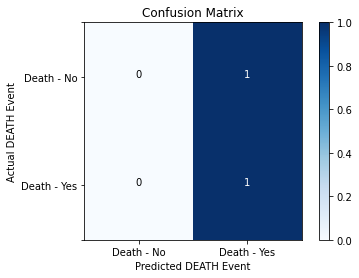

In [25]:
cf = confusion_matrix(actual, y_pred)
plt.imshow(cf, cmap=plt.cm.Blues, interpolation="nearest")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted DEATH Event")
plt.ylabel("Actual DEATH Event")
class_labels = ["Death - No", "Death - Yes"]
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks([-0.5, 0, 1, 1.5], ["", "Death - No", "Death - Yes", ""])
# plotting text value inside cells
thresh = cf.max() / 2.0
for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
    plt.text(
        j,
        i,
        format(cf[i, j], "d"),
        horizontalalignment="center",
        color="white" if cf[i, j] > thresh else "black",
    )
plt.show()

Print the logs of the web service and delete the service

In [26]:
print(service.get_logs())

2022-04-08T11:16:49,219333100+00:00 - gunicorn/run 
2022-04-08T11:16:49,219437400+00:00 - rsyslog/run 
2022-04-08T11:16:49,219438200+00:00 - iot-server/run 
Dynamic Python package installation is disabled.
Starting HTTP server
2022-04-08T11:16:49,260870800+00:00 - nginx/run 
rsyslogd: /azureml-envs/azureml_2039c3f5cc4ae631ef3fdf7a2e093d5a/lib/libuuid.so.1: no version information available (required by rsyslogd)
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
2022-04-08T11:16:49,497146600+00:00 - iot-server/finish 1 0
2022-04-08T11:16:49,499894100+00:00 - Exit code 1 is normal. Not restarting iot-server.
Starting gunicorn 20.1.0
Listening at: http://127.0.0.1:31311 (85)
Using worker: sync
worker timeout is set to 300
Booting worker with pid: 112
SPARK_HOME not set. Skipping PySpark Initialization.
Initializing logger
2022-04-08 11:16:51,031 | root | INFO | Starting up app insights client
logging socket was found. logging is available.
logging socket was found.

In [ ]:
# delete the service
service.delete()
model_automl.delete()
compute_cluster.delete()

**Submission Checklist**
- I have registered the model.
- I have deployed the model with the best accuracy as a webservice.
- I have tested the webservice by sending a request to the model endpoint.
- I have deleted the webservice and shutdown all the computes that I have used.
- I have taken a screenshot showing the model endpoint as active.
- The project includes a file containing the environment details.
